# Test SR model

In [ ]:
import numpy as np 
import torch
from PIL import Image
import matplotlib.pyplot as plt

# 假设你的项目路径配置正确
from src.emcfsys.EMCellFiner.hat.models.hat_model import HATModel
from src.emcfsys.EMCellFiner.hat.models.img_utils import tensor2img

# 1. 初始化模型
path = r"D:\napari_EMCF\EMCFsys\models\EMCellFiner.pth"
# 显式指定 tile_size，防止显存溢出；对于小图可以不用 tile
model = HATModel(scale=4, tile_size=512) 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# 2. 读取与预处理
img_path = r"D:\napari_EMCF\EMCFsys\emcfsys\image\Bock2011_2951_XrV1ciGgTWHjepNf.tif"
img = Image.open(img_path).convert("RGB")

# 转换为 Numpy 并归一化
img_np = np.array(img).astype(np.float32) / 255.
# 转换为 Tensor: (H, W, C) -> (C, H, W) -> (1, C, H, W)
img_torch = torch.from_numpy(img_np).permute(2, 0, 1).unsqueeze(0).to(device)
print(f"Input Shape: {img_torch.shape}")
# 3. 推理
with torch.no_grad():
    output = model(img_torch) 
print(f"Output Shape: {output.shape}")
# 4. 后处理
output = output.cpu()
img_out = tensor2img(output, rgb2bgr=False, min_max=(0, 1))
# 5. 转回 PIL 图片
img_final = Image.fromarray(img_out)

# 验证结果
# img_final.show() 
# img_final.save("result_sr.png")
print("Done.")

In [ ]:
from src.emcfsys.EMCellFiner.hat.models.inference_hat import hat_infer_numpy
from src.emcfsys.EMCellFiner.hat.models.hat_model import HATModel
from PIL import Image
import numpy as np
import torch
import time
start = time.time()
img_path = r"D:\napari_EMCF\EMCFsys\emcfsys\image\Bock2011_2951_XrV1ciGgTWHjepNf.tif"
img = Image.open(img_path).convert("RGB")
img_np = np.array(img)

model = HATModel(scale=4, tile_size=512)
device = "cuda" #torch.device("cuda" if torch.cuda.is_available() else "cpu")

out = hat_infer_numpy(
    model= model,
    image= img_np,
    device=device,
)
print(out.shape)
end = time.time()
print("inference time: ", end - start)

In [ ]:
out

# test SR stack images

In [ ]:
from src.emcfsys.EMCellFiner.hat.models.inference_hat import hat_infer_numpy
from src.emcfsys.EMCellFiner.hat.models.hat_model import HATModel
from PIL import Image
import numpy as np
import torch
import time
start = time.time()
# img_path = r"D:\napari_EMCF\EMCFsys\emcfsys\image\Bock2011_2951_XrV1ciGgTWHjepNf.tif"
# img = Image.open(img_path).convert("RGB").crop([0,0,512,512])

stack_path = [r"D:\CellChange\Bock3D\image\3004.jpg",
              r"D:\CellChange\Bock3D\image\3044.jpg",
              r"D:\CellChange\Bock3D\image\3054.jpg",]

# stack_path = [r"D:\CellChange\Bock3D\image\3004.jpg",]

stack_imgs = np.array([np.array(Image.open(p).convert("L").resize([1024,1024])) for p in stack_path])


model = HATModel(scale=4, tile_size=512)
device = "cuda" #torch.device("cuda" if torch.cuda.is_available() else "cpu")

out = hat_infer_numpy(
    model = model,
    image = stack_imgs,
    device =device,
)

end = time.time()
print("inference time: ", end - start)

In [ ]:
from urllib.request import urlopen
from PIL import Image
import timm

img = Image.open(urlopen(
    'https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/beignets-task-guide.png'
))

model = timm.create_model('vit_small_patch16_dinov3.lvd1689m', pretrained=True)
model = model.eval()

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)

output = model(transforms(img).unsqueeze(0))  # unsqueeze single image into batch of 1

top5_probabilities, top5_class_indices = torch.topk(output.softmax(dim=1) * 100, k=5)


# test the train

In [ ]:
from src.emcfsys.EMCellFound.train import train_loop
import torch
img_dir = r"D:\ZJU-CUHK AI collab\QC\DL\masks\image"
label_dir = r"D:\ZJU-CUHK AI collab\QC\DL\masks\label"
save_dir = r"D:\ZJU-CUHK AI collab\QC\DL\masks\models"

logs = []
epoch_times = []
metrics_all = []
def cb(epoch, batch, n_batches, loss, finished_epoch=False, epoch_time=None, model_dict=None, metrics=None):

    # 保存 epoch 时间
    if finished_epoch and epoch_time is not None:
        epoch_times.append(epoch_time)

    if metrics is not None:
        metrics_all.append(metrics)
        
    # 保存 batch/epoch 日志
    logs.append((epoch, batch, n_batches, loss, finished_epoch, epoch_time, metrics))

    # 输出日志
    if batch == 0 and finished_epoch:
        if epoch_time is not None:
            print(f"Epoch {epoch} finished, avg loss {loss:.4f}, time {epoch_time:.2f}s, metric {metrics}" )


train_loop(img_dir, 
           label_dir, 
           save_dir, 
           model_name='unet',
           backbone_name='convnext_base',
           pretrained = True,
           pretrained_model=None,
           lr=1e-4, batch_size=8, 
           epochs=1000, device=None,
           callback=cb, target_size=(1024, 1024),
           classes_num=4, ignore_index=-1)

In [ ]:
New best model found at epoch 84! Val IoU=0.7845
New best model found at epoch 34! Val IoU=0.7566

# Inference the seg model

In [ ]:
from src.emcfsys.EMCellFound.inference import infer_numpy, load_model
from src.emcfsys.EMCellFound.utils.checkpoint import load_pretrained
import numpy as np
import torch
from PIL import Image
from src.emcfsys.EMCellFound.models.model_factory import get_model
from src.emcfsys.EMCellFound.models.DeepLabv3Plus import DeepLabV3Plus

# img_path = r"D:\napari_EMCF\EMCFsys\emcfsys\image\Bock2011_2951_xZGgUFHBDISQMdco.tif"
img_path = r"D:\CellChange\Bock3D\image\3004.jpg"


model_path = r"D:\napari_EMCF\EMCFsys\models\best_model_epoch99_IoU=0.8046.pth"
# 构建 + 加载模型
model = load_model(model_name="deeplabv3plus", 
                   backbone_name="emcellfound_vit_base", 
                   num_classes=2, 
                   model_path=model_path, 
                   aux_on=False, 
                   device="cuda")

# 加载图像
img = np.array(Image.open(img_path).convert("RGB").resize((512, 512)))

# 推理
mask = infer_numpy(model, img, device="cuda")
print(mask.shape, np.unique(mask))
Image.fromarray(mask*255)

# test the infer_numpy function

In [ ]:
from src.emcfsys.EMCellFound.inference import infer_numpy, load_model, infer_full_image
from src.emcfsys.EMCellFound.utils.checkpoint import load_pretrained
import numpy as np
import torch
from PIL import Image
from src.emcfsys.EMCellFound.models.model_factory import get_model
from src.emcfsys.EMCellFound.models.DeepLabv3Plus import DeepLabV3Plus


img_path = r"D:\napari_EMCF\EMCFsys\emcfsys\image\Bock2011_2951_xZGgUFHBDISQMdco.tif"

stack_path = [r"D:\CellChange\Bock3D\image\3004.jpg",
              r"D:\CellChange\Bock3D\image\3014.jpg",
              r"D:\CellChange\Bock3D\image\3024.jpg",
              r"D:\CellChange\Bock3D\image\3034.jpg",
              r"D:\CellChange\Bock3D\image\3044.jpg",
              r"D:\CellChange\Bock3D\image\3054.jpg",]

# stack_path = [r"D:\CellChange\Bock3D\image\3004.jpg",]

stack_imgs = np.array([np.array(Image.open(p).convert("RGB")) for p in stack_path])
print(stack_imgs.shape)


model_path = r"D:\napari_EMCF\EMCFsys\models\best_model_epoch99_IoU=0.8046.pth"

# 构建 + 加载模型

model = load_model(model_name="deeplabv3plus", 
                   backbone_name="emcellfound_vit_base", 
                   num_classes=2, 
                   model_path=model_path, 
                   aux_on=False, 
                   device="cuda")

# 加载图像

# 推理
mask = infer_full_image(model, stack_imgs, (512,512), device="cuda")
print(mask.shape, np.unique(mask))


# Test slide inference

In [ ]:
from src.emcfsys.EMCellFound.inference import infer_numpy, load_model, infer_full_image, infer_sliding_window
from src.emcfsys.EMCellFound.utils.checkpoint import load_pretrained
import numpy as np
import torch
from PIL import Image
from src.emcfsys.EMCellFound.models.model_factory import get_model
from src.emcfsys.EMCellFound.models.DeepLabv3Plus import DeepLabV3Plus


img_path = r"D:\napari_EMCF\EMCFsys\emcfsys\image\Bock2011_2951_xZGgUFHBDISQMdco.tif"

stack_path = [r"D:\CellChange\Bock3D\image\3004.jpg",
              r"D:\CellChange\Bock3D\image\3014.jpg",
              r"D:\CellChange\Bock3D\image\3024.jpg",
              r"D:\CellChange\Bock3D\image\3034.jpg",
              r"D:\CellChange\Bock3D\image\3044.jpg",
              r"D:\CellChange\Bock3D\image\3054.jpg",]

# stack_path = [r"D:\CellChange\Bock3D\image\3004.jpg",]

stack_imgs = np.array([np.array(Image.open(p).convert("RGB")) for p in stack_path])
print(stack_imgs.shape)


model_path = r"D:\napari_EMCF\EMCFsys\models\best_model_epoch98_IoU=0.9024.pth"

# 构建 + 加载模型

model = load_model(model_name="deeplabv3plus", 
                   backbone_name="emcellfound_vit_base", 
                   num_classes=2, 
                   model_path=model_path, 
                   aux_on=False, 
                   device="cuda")

# 加载图像

# 推理

mask = infer_sliding_window(model=model, image=stack_imgs, window_size= 512, 
    overlap = 0.25, out_channels=2, img_size = (512,512), device = "cuda",)

print(mask.shape, np.unique(mask))


In [ ]:
from PIL import Image
import numpy as np
import skimage
img = Image.open(r"D:\ZJU-CUHK AI collab\RAYdata\test_data0086.tif")
img_np_32bit = np.array(img)
print(img_np_32bit)

print("32bit:", img_np_32bit.max())
print("8bit:", img_np_32bit.astype(np.uint8).max())

sk_img = skimage.io.imread(r"D:\ZJU-CUHK AI collab\RAYdata\test_data0086.tif").astype(np.uint8)
print("skimage 8bit:", sk_img.max())

In [ ]:
from PIL import Image
import numpy as np
img = Image.open(r"D:\ZJU-CUHK AI collab\RAYdata\0008bit.tif")
img_np = np.array(img)
img_np.max()

In [ ]:
import numpy as np

def normalize_to_uint8(
    img,
    method="percentile",
    pmin=1,
    pmax=99,
    eps=1e-8
):
    """
    Robustly normalize arbitrary numpy image to uint8 [0,255].

    Parameters
    ----------
    img : np.ndarray
        Input image of any dtype (uint8/16/32/float/etc.)
    method : str
        'minmax' or 'percentile'
    pmin, pmax : float
        Percentiles used when method='percentile'
    eps : float
        Small value to avoid division by zero
    """

    if img is None:
        raise ValueError("Input image is None")

    img = np.asarray(img)

    # 1. already uint8 → return safely
    if img.dtype == np.uint8:
        return img

    # 2. convert to float32
    img_f = img.astype(np.float32)

    # 3. handle NaN / Inf
    img_f = np.nan_to_num(img_f, nan=0.0, posinf=0.0, neginf=0.0)

    # 4. determine range
    if method == "minmax":
        vmin = img_f.min()
        vmax = img_f.max()
    elif method == "percentile":
        vmin = np.percentile(img_f, pmin)
        vmax = np.percentile(img_f, pmax)
    else:
        raise ValueError(f"Unknown method: {method}")

    # 5. avoid degenerate case
    if abs(vmax - vmin) < eps:
        return np.zeros_like(img_f, dtype=np.uint8)

    # 6. normalize
    img_norm = (img_f - vmin) / (vmax - vmin)
    img_norm = np.clip(img_norm, 0.0, 1.0)

    # 7. map to uint8
    return (img_norm * 255).astype(np.uint8)


In [ ]:
normalize_to_uint8(img_np).max()

In [ ]:
from PIL import Image
import numpy as np

img = Image.open(r"D:\ZJU-CUHK AI collab\RAYdata\test_data0086.tif")
img_np_32bit = np.array(img)
print(img_np_32bit)

print("32bit:", img_np_32bit.max())
print("8bit:", img_np_32bit.astype(np.uint8).max())

normalize_img = normalize_to_uint8(img_np_32bit)
print("normalized 8bit:", normalize_img.max())

# Inference Segmentation Models in a Folder

In [ ]:
from src.emcfsys.EMCellFound.inference import load_model, infer_sliding_window
import numpy as np
import torch
from PIL import Image
import os
from tqdm import tqdm
img_folder = r"Z:\3Ddataset\Guo3DCell\save"
save_folder = r"Z:\3Ddataset\Guo3DCell\mask_membrane"
# 1. save mask folder first
if not os.path.exists(save_folder):
    os.makedirs(save_folder)


stack_path = [os.path.join(img_folder, f) for f in os.listdir(img_folder) if f.endswith(".tif")]
print(stack_path)



# 2. load the model
model_path = r"Z:\3Ddataset\Guo3DCell\outputMembrane\Guo3DMembrane\models\EMCF_Unet_IoU=0.7849.pth"

model = load_model(model_name="unet", 
                   backbone_name="emcellfound_vit_base", 
                   num_classes=2, 
                   model_path=model_path, 
                   aux_on=False, 
                   device="cuda")

# 3. load the images one by one and infer
# if stack_path has lots of images, there could be memory issue
# So we process one by one and save to disk
# windows size 1536 works better for large images; img_size is set to 512x512 to fit model input
for p in tqdm(stack_path):
    image = Image.open(p).convert("RGB")
    stack_imgs = np.array([np.array(image)])
    
    mask = infer_sliding_window(model=model, image=stack_imgs, window_size= 1536, 
        overlap = 0.2, out_channels=2, img_size = (512,512), device = "cuda",)
    
    # 4. save the binary mask to disk
    _ = Image.fromarray(mask[0].astype(np.uint8)*255).save(save_folder + "/" + os.path.basename(p).replace(".tif", ".png"))


    # 5. paste the mask using a green color to original image and save to disk for visualization
    img = image.convert("RGBA")
    color_img = Image.new("RGBA", img.size, (42, 215, 22, 0))
    mask_alpha = (mask[0] * 128).astype(np.uint8)  # 0~128
    mask_alpha = Image.fromarray(mask_alpha, mode="L")
    color_img.putalpha(mask_alpha)
    overlay = Image.alpha_composite(img, color_img)
    overlay = overlay.convert("RGB")
    _ = overlay.save(save_folder + "/" + os.path.basename(p).replace(".tif", "_overlay.jpg"))
    



In [1]:
from src.emcfsys.PhenotypeAnalysis.functions import analyze_phenotypes
import numpy as np
from PIL import Image
imgs = Image.open(r"E:\Papers\BaiduSyncdisk\01Yzy博士毕业论文\论文图片\第六章\Bock2011_2951_xZGgUFHBDISQMdco.tif")
mask_path = r"E:\Papers\BaiduSyncdisk\01Yzy博士毕业论文\论文图片\第六章\Bock2011_2951_xZGgUFHBDISQMdco_dl_mask.tif"

img = np.array(imgs)
mask = np.array(Image.open(mask_path))
features, mask = analyze_phenotypes(img, mask, {"Area":True, "Perimeter":True, "Elongation":True})


c:\Users\YZY\miniconda3\envs\EMCF_napari\Lib\site-packages\timm\models\registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


Detected semantic mask. Found 9 instances.


In [2]:
features

label  centroid-0  centroid-1     area   perimeter  elongation
0      0  123.467884  795.306925  40681.0  789.293506    1.326498
1      1  103.705577   96.472724  13107.0  446.374675    1.126903
2      2  327.205922  677.728344  12733.0  518.658946    2.860255
3      3  420.593730  441.834405   6220.0  292.592929    1.097934
4      4  458.313316  796.154564  26261.0  733.043723    2.585105
5      5  632.272176  641.344958   2638.0  190.752309    1.250001
6      6  719.388002  252.620077   4951.0  264.894444    1.291624
7      7  766.968758  956.167827  19973.0  586.232539    1.223905
8      8  901.147875  623.456959   8399.0  399.462987    2.405656

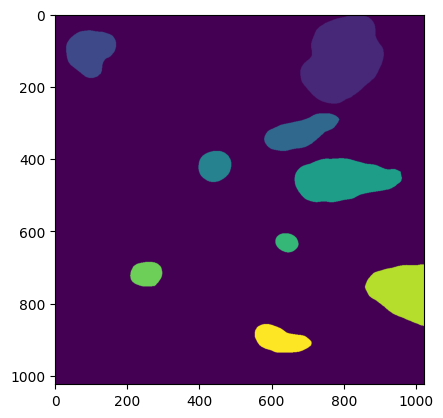

In [3]:
import matplotlib.pyplot as plt
plt.imshow(mask)

In [11]:
from PIL import Image
import numpy as np

root = r"Z:\3Ddataset\Guo3DCell\ROI02_ERContact\train_dataset _128low\label"
save_dir = r"Z:\3Ddataset\Guo3DCell\ROI02_ERContact\train_dataset _128low\label_low"
os.makedirs(save_dir, exist_ok=True)
import os
for name in os.listdir(root):
    if name.endswith(".png"):
        img = Image.open(os.path.join(root, name)).resize((128, 128), Image.BILINEAR).save(os.path.join(save_dir, name))
        print(np.unique(np.array(img)))
        
        

[None]
[None]
[None]
[None]
[None]
[None]
[None]
[None]
[None]
[None]
[None]
